# 1. Install PIP's

In [348]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


# 2. Import Packages

In [349]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [350]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [351]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [352]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [353]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates

In [354]:
full_df = full_df.drop_duplicates(subset=['review_id'])

### 4.5. Drop NA

In [355]:
full_df = full_df.dropna(subset=['review_comment_message'])
full_df = full_df.dropna(subset=['review_score'])

### 4.6. Merge Title with Message

In [356]:
full_df['review_comment_title'] = full_df['review_comment_title'].fillna('').astype(str)
full_df['text_sentiment'] = full_df['review_comment_title'].str.cat(full_df['review_comment_message'], sep=' ')

### 4.7. Drop NA Text Sentiment

In [357]:
full_df = full_df.dropna(subset=['text_sentiment'])

# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [358]:
def to_lower(text):
    return text.lower()

In [359]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [360]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [361]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [362]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [363]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [364]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [365]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [366]:
def remove_accent(text):
    return unidecode(text)

In [367]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [368]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [369]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [370]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [371]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [372]:
def strip_text(text):
    return text.strip()

In [373]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjetivos, Verbos, Substantivo, Adverbios and "nao" "nada"

In [374]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [375]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization

In [376]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [377]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

In [400]:
def remove_word(text, word):
    return text.replace(word, '')

In [403]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lambda x: remove_word(x, 'produto'))

In [404]:
full_df.head(20)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,text_sentiment
0,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454,nao testar ainda vir correto bom condicoes apenas caixa vir bem amassar danificar ficar chato tratar presente
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o .,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727,muito bom loja muito bom
448,359d03e676b3c069f62cadba8dd3f6e8,5,,O foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299,exatamente esperar descrito site chegar bem antes data prever
620,e07549ef5311abcc92ba1784b093fb56,2,,fiquei triste por n ter me atendido.,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111,fiquei triste n atendir
1468,15898b543726a832d4137fbef5d1d00e,1,,Aguardando retorno da loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869,aguardar retorno lojar
2180,8f39f09c22b1ceb6e3eb178d8e50bb8a,4,,Gostei do,2018-03-13,2018-03-14 10:36:16,72d3bf1d3a790f8874096fcf860e3eff,-26.916270,-48.652460,gostar
2415,5a8608437f4b52bec5cd143f37258b5e,5,Nota dez,Obrigado pela atenção. Lojas lannister perfeito em tudo.,2018-07-03,2018-07-03 15:10:07,009c09f439988bc06a93d6b8186dce73,-15.836123,-48.040185,nota obrigado atencao loja perfeito
2881,38cae21b1b57a95959440380d5b2ef7a,2,,"os correios estäo em greve... näo recebi nenhum aviso de atraso, mas de qqer forma a empresa responsável deveria dar alguma resposta sobre o atraso.",2017-10-01,2017-10-01 17:55:21,5ac9d9e379c606e36a8094a6046f75dc,-23.677741,-46.668647,Correios greve nao receber aviso atraso qqer forma empresa responsavel dever dar resposta atraso
3240,9a55cbc65c8fad47581da5ebbb2b373e,5,Ótimo,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,2018-08-14 21:52:46,e99d69efe684efaa643f99805f7c81bc,-21.728866,-48.688815,otimo sempre comprar aqui pois bom parabens
3308,6a1a8e54de03ab98e6e8ff56e56e507f,2,,Demora muito entregar. Já passou o prazo e ainda não recebi minha encomenda.,2018-03-16,2018-03-20 23:10:58,7b717060aa783eb7f23a747a3a733dd7,-23.624784,-46.539542,demorar muito entregar passar prazo ainda nao recebi encomenda


# 6. Previus Analyze

In [379]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,40095,a54f0611adc9ed256b57ede6b6eb5114,15.29
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,0,4089,,3.22
3,review_comment_message,object,0,35625,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",14.78
4,review_creation_date,datetime64[ns],0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,datetime64[ns],0,40069,2017-10-12 03:43:48,15.29
6,product_id,object,0,17970,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82
9,text_sentiment,object,0,32713,nao testar produto ainda vir correto bom condicoes apenas caixa vir bem amassar danificar ficar chato tratar presente,14.27


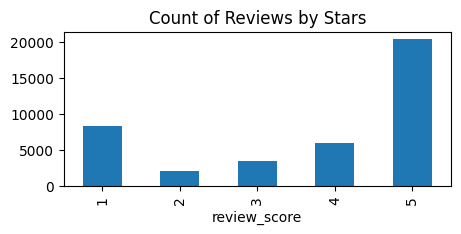

In [380]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [381]:
example = full_df['text_sentiment'].iloc[4]
print(example)

aguardar retorno lojar


# 7. Training Model

### 7.1. Separeting Dataframe Training and Dataframe Test After Training

In [424]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.99, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

### 7.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [425]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2] else 1)

In [426]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,text_sentiment,sentiment
0,ca3199bb0d98c494fd25dbf79e50e661,5,,Uahlll! Recebi minha compra 30 dias antes do prazo definido! Adorei comprar da targaryen!,2017-01-17,2017-01-17 12:50:12,7ead55b1f52de17d6dac82001470b2a2,-25.511232,-49.303111,recebi compra dia antes prazo definir adorar comprar,1
1,65e1734b87fcf83d834e141e1deee410,5,,Adorei o relógio e chegou rápido!,2017-12-30,2017-12-30 21:38:37,8317b177579dd27ff068b83205e2169b,-21.362358,-48.232976,adorei relogio chegar rapido,1
2,5c1ba09de5c746017d406bd2cfefeca3,3,nao entrega do produto,recebe apenas 01 peça do ! estou precisando da 2 peças restante!,2018-04-26,2018-04-26 13:36:47,25c38557cf793876c5abdd5931f922db,-22.760478,-47.412811,nao entregar receber apenas pecar precisar peca restante,1
3,a3d3d770c3574d9847e5ed349a1e142e,5,Ótimo,Muito bom,2018-05-08,2018-05-11 00:42:40,7bdc3ff2d6af39d08fb40546ba7b9766,-26.859080,-48.639536,otimo muito bom,1
4,2dc6a14196ad670861710b19f3d5df6f,1,,Já passou 3 dias e o não foi entregue.,2017-06-30,2017-07-01 15:32:17,f811e4e8228504bcdd34f2fe9f502c92,-23.606632,-46.668066,passar dia nao entregar,0


### 7.3. Selecting Columns Necessary for Training

In [427]:
selected_columns = ['text_sentiment', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [428]:
df_classification.head(5)

,text_sentiment,sentiment
0,recebi compra dia antes prazo definir adorar comprar,1
1,adorei relogio chegar rapido,1
2,nao entregar receber apenas pecar precisar peca restante,1
3,otimo muito bom,1
4,passar dia nao entregar,0


### 7.4. Divising Dataframe Between Train and Test

In [429]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['text_sentiment'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 7.5. Inicializing Training IA

In [430]:
vectorizer = TfidfVectorizer()

In [431]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

In [432]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [433]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [434]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

In [435]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(32,16,16,1),
                                   activation='relu',
                                   solver='adam',
                                   learning_rate='constant',
                                   max_iter=1000,
                                   early_stopping=True,
                                   n_iter_no_change=25,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.54918719
Validation score: 0.874947
Iteration 2, loss = 0.37896659
Validation score: 0.892994
Iteration 3, loss = 0.30058329
Validation score: 0.895329
Iteration 4, loss = 0.25495410
Validation score: 0.898301
Iteration 5, loss = 0.22157448
Validation score: 0.903185
Iteration 6, loss = 0.19665934
Validation score: 0.900637
Iteration 7, loss = 0.17882037
Validation score: 0.913588
Iteration 8, loss = 0.16277934
Validation score: 0.909766
Iteration 9, loss = 0.15076285
Validation score: 0.911253
Iteration 10, loss = 0.14060160
Validation score: 0.912102
Iteration 11, loss = 0.13181301
Validation score: 0.909554
Iteration 12, loss = 0.12468491
Validation score: 0.910403
Iteration 13, loss = 0.12018499
Validation score: 0.911677
Iteration 14, loss = 0.11366409
Validation score: 0.912314
Iteration 15, loss = 0.11045531
Validation score: 0.912102
Iteration 16, loss = 0.10672897
Validation score: 0.909766
Iteration 17, loss = 0.10432044
Validation score: 0.913800
Iterat

# 8. Analyze Performance IA

### 8.1. Score

In [436]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8606877440483688

### 8.2. Graph Loss and Score During Training

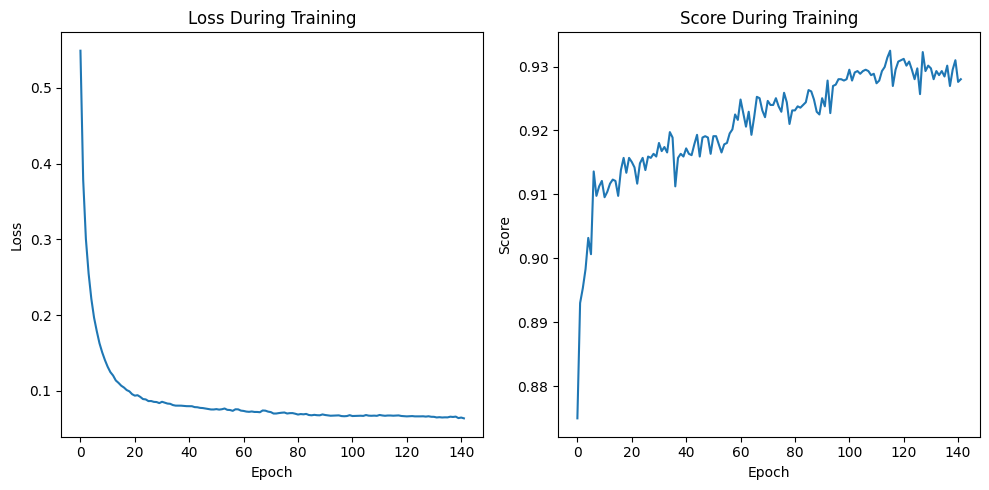

In [437]:
plt.figure(figsize=(10, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.validation_scores_)
plt.title('Score During Training')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 8.3. Confusion Matrix

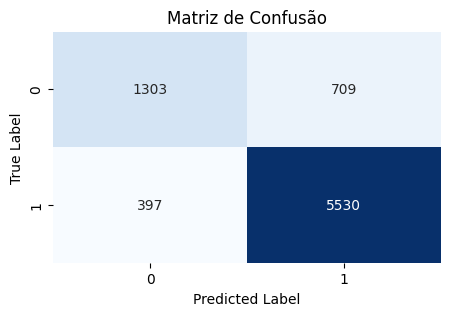

In [438]:
predictions = analyze_sentiment.predict(X_test)
conf_matrix = confusion_matrix(sentiment_test, predictions)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 8.4. Curve ROC

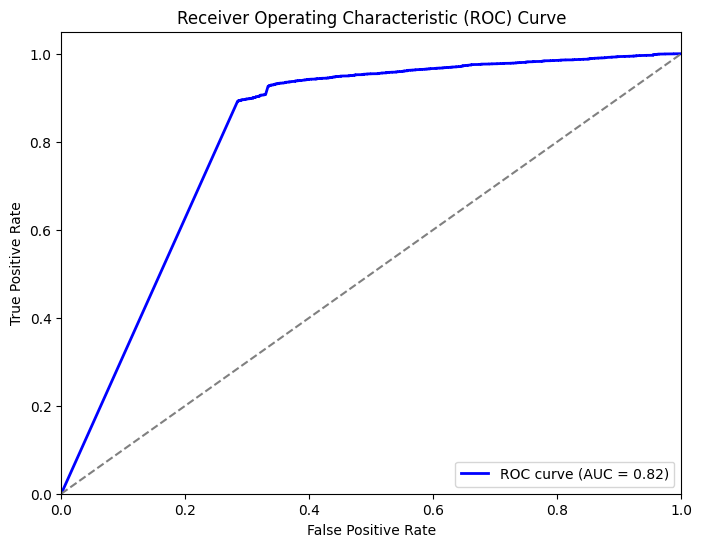

In [439]:
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Test and Deploy IA

In [440]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = vectorizer.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['text_sentiment', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message','text_sentiment', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                     text_sentiment  \
0          otimo indico  alto qualidade recebi antes prazo combinar   
1               mais bonito esperar tecido lindo ficar lindo janela   
2                    entregar rapir bem antes prever bem satisfeito   
3                     vir prazo vir super rapido adoreer recomender   
4                                          vir muito rapido obrigar   
...                                                             ...   
39991  otimar comprar site mercadoria chegar antes prazo determinar   
39992           nao mini Cajon Shaker Chocalho imitar cajon pessimo   
39993                                    so pecar vir rachar bem rs   
39994                                          entregar antes prazo   
39995                                entregar somente querer saber    

       review_score sentimento_predito  
0                 5           positivo  
1                 5           positivo  
2                 5     

In [422]:
from collections import Counter

# Filtrar mensagens positivas e negativas
mensagens_positivas = df_remaining[df_remaining['sentimento_predito'] == 'positivo']['text_sentiment']
mensagens_negativas = df_remaining[df_remaining['sentimento_predito'] == 'negativo']['text_sentiment']

# Função para contar palavras mais comuns
def contar_palavras(mensagens):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    return contagem_palavras.most_common(10)

# Contar palavras mais comuns para mensagens positivas
print("Palavras mais comuns em mensagens positivas:")
print(contar_palavras(mensagens_positivas))

# Contar palavras mais comuns para mensagens negativas
print("\nPalavras mais comuns em mensagens negativas:")
print(contar_palavras(mensagens_negativas))

Palavras mais comuns em mensagens positivas:
[('entregar', 7518), ('muito', 6961), ('prazo', 6053), ('bom', 6047), ('nao', 5251), ('antes', 5241), ('chegar', 4494), ('otimo', 3546), ('bem', 2469), ('qualidade', 2228)]

Palavras mais comuns em mensagens negativas:
[('nao', 6918), ('entregar', 3880), ('recebi', 2653), ('comprar', 2474), ('prazo', 2265), ('vir', 1927), ('chegar', 1845), ('muito', 1369), ('ainda', 1229), ('bom', 1201)]


## division

In [346]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)

ValueError: Found input variables with inconsistent numbers of samples: [41626, 31755]